In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

import torch
import torch.nn as nn

In [2]:
%%time
df = pd.read_excel('./indeed_results_pp_2020-04-25.xlsx')

Wall time: 14.6 s


In [3]:
new_df = df[(df['Title_New'].notnull()) & (df['Salary_Average'] != 0)][['Time', 'Title_New', 'Salary_Average', 'Salary_Unit_Day', 'Salary_Unit_Hour', 'Salary_Unit_Month', 'Salary_Unit_Week', 'Salary_Unit_Year']].sort_values(by='Time').reset_index().drop(['index'], axis=1)

In [4]:
new_df['Time'] = new_df['Time'].apply(lambda x: np.datetime64(f'{x}'))

In [5]:
new_df

,Time,Title_New,Salary_Average,Salary_Unit_Day,Salary_Unit_Hour,Salary_Unit_Month,Salary_Unit_Week,Salary_Unit_Year
0,2019-10-24,graphic designer,16000,0,0,1,0,0
1,2019-10-24,graphic designer,16000,0,0,1,0,0
2,2019-10-24,graphic designer,32500,0,0,1,0,0
3,2019-10-26,graphic designer,14000,0,0,1,0,0
4,2019-10-27,front end developer,20000,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1332,2020-04-24,web developer,350000,0,0,0,0,1
1333,2020-04-24,machine learning developer,550000,0,0,0,0,1
1334,2020-04-24,front end developer,1100000,0,0,0,0,1
1335,2020-04-24,back end developer,32500,0,0,1,0,0


In [6]:
new_df.dtypes

Time                 datetime64[ns]
Title_New                    object
Salary_Average                int64
Salary_Unit_Day               int64
Salary_Unit_Hour              int64
Salary_Unit_Month             int64
Salary_Unit_Week              int64
Salary_Unit_Year              int64
dtype: object

In [7]:
y = new_df[(new_df['Title_New'] == 'graphic designer') & (new_df['Salary_Unit_Month'] == 1)][['Time', 'Title_New', 'Salary_Average']].groupby(by='Time').mean()

In [8]:
y.head()

,Salary_Average
Time,
2019-10-24,21500.000000
2019-10-26,14000.000000
2019-10-27,18000.000000
2019-10-30,22500.000000
2019-11-02,18166.666667


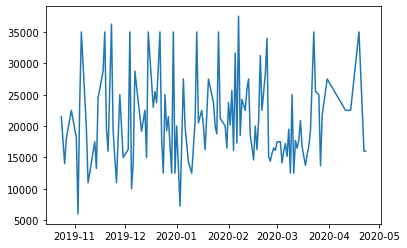

In [9]:
plt.plot(y.index, y['Salary_Average'])

In [10]:
test_size = 10
train_set = y[:-test_size].values
test_set = y[-test_size:]

In [39]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1).cuda()
window_size = 5

def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    
    return out

train_data = input_data(train_norm, window_size)

In [63]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden = (
            torch.zeros(1, 1, hidden_size),
            torch.zeros(1, 1, hidden_size)
        )
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden
        )
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        return pred[-1]

In [64]:
torch.manual_seed(101)

model = LSTMnetwork().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [65]:
%%time
epochs = 1000

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                       torch.zeros(1, 1, model.hidden_size).cuda())
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    if (i+1) % 100 == 0:
        print(f'Epoch {i+1} Loss {loss.item()}')

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cpu and hidden tensor at cuda:0

In [56]:
%%time
future = 10

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                       torch.zeros(1, 1, model.hidden_size).cuda())
        
        preds.append(model(seq).item())

Wall time: 6.98 ms


In [57]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

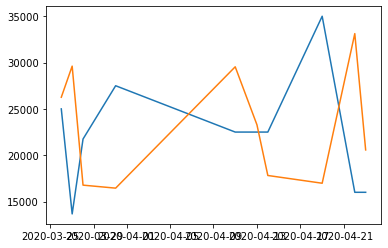

In [58]:
plt.plot(test_set.index, test_set.values)
plt.plot(test_set.index, true_predictions)

In [59]:
sqrt(mean_squared_error(test_set.values.reshape(-1), true_predictions)) / test_set * 100

,Salary_Average
Time,
2020-03-26,42.218902
2020-03-27,77.229699
2020-03-28,48.527474
2020-03-31,38.380820
2020-04-11,46.909891
2020-04-13,46.909891
2020-04-14,46.909891
2020-04-19,30.156359
2020-04-22,65.967035


In [60]:
sqrt(mean_squared_error(test_set.values.reshape(-1), true_predictions))

10554.72555360897